In [40]:
import os
import torch
import torchvision
import numpy as np
from PIL import Image
from skimage import io, color, filters, measure, morphology, feature
from skimage.draw import polygon_perimeter
from scipy import ndimage
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt

In [2]:
# Set paths
image_folder = 'ant_images'
output_folder = 'segmented_ants'
os.makedirs(output_folder, exist_ok=True)

# Load pretrained Mask R-CNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval().to(device)

# Threshold for confidence
CONFIDENCE_THRESHOLD = 0.7

/home/antonxue/lib/miniconda3/envs/tfl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/antonxue/lib/miniconda3/envs/tfl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def process_image(image_path):
    image = Image.open(image_path).convert("RGB")
    tensor = F.to_tensor(image).to(device)
    return image, tensor

In [5]:
def segment_and_count(image_path):
    orig_img, img_tensor = process_image(image_path)
    with torch.no_grad():
        prediction = model([img_tensor])[0]

    masks = prediction['masks'] > 0.5
    scores = prediction['scores']

    # Keep only confident detections
    keep = [i for i, score in enumerate(scores) if score > CONFIDENCE_THRESHOLD]
    num_ants = len(keep)

    # Convert to numpy image for annotation
    np_image = np.array(orig_img)

    # Overlay contours for each kept mask
    for i in keep:
        mask = masks[i][0].mul(255).byte().cpu().numpy()
        # Find where the mask is present
        ys, xs = np.where(mask > 0)
        if len(xs) == 0 or len(ys) == 0:
            continue
        rr, cc = polygon_perimeter(ys, xs, shape=mask.shape, clip=True)
        np_image[rr, cc] = [0, 255, 0]  # draw green outline

    # Save annotated image
    save_path = os.path.join(output_folder, os.path.basename(image_path))
    io.imsave(save_path, np_image)

    return num_ants

In [6]:
# # Run on all images in folder
# for fname in sorted(os.listdir(image_folder)):
#     if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
#         img_path = os.path.join(image_folder, fname)
#         # break
#         count = segment_and_count(img_path)
#         print(f'{fname}: {count} ants')

In [7]:
orig_img, img_tensor = process_image(img_path)

NameError: name 'img_path' is not defined

In [ ]:
with torch.no_grad():
    prediction = model([img_tensor])[0]

In [ ]:
def find_ant_centers(image_path, sigma=2.0, min_size=30, max_size=500):
    """
    Detects ant-like object centers in an image using edge detection and component labeling.

    Args:
        image_path (str): Path to image.
        sigma (float): Smoothing for Canny edge detection.
        min_size (int): Minimum region size.
        max_size (int): Maximum region size.

    Returns:
        input_points (List[[[x, y]]]): List of input points for SAM.
    """
    image = io.imread(image_path)
    gray = color.rgb2gray(image)

    # Step 1: Edge detection
    edges = feature.canny(gray, sigma=sigma)

    # Step 2: Morphological closing to fill small gaps in edges
    filled = morphology.binary_closing(edges, morphology.disk(2))

    # Step 3: Fill enclosed regions
    filled = morphology.binary_fill_holes(filled)

    # Step 4: Remove tiny noise
    cleaned = morphology.remove_small_objects(filled, min_size=min_size)

    # Step 5: Label and get region centroids
    labeled = measure.label(cleaned)
    props = measure.regionprops(labeled)

    input_points = []
    for region in props:
        if min_size < region.area < max_size:
            y, x = region.centroid
            input_points.append([[int(x), int(y)]])

    return input_points

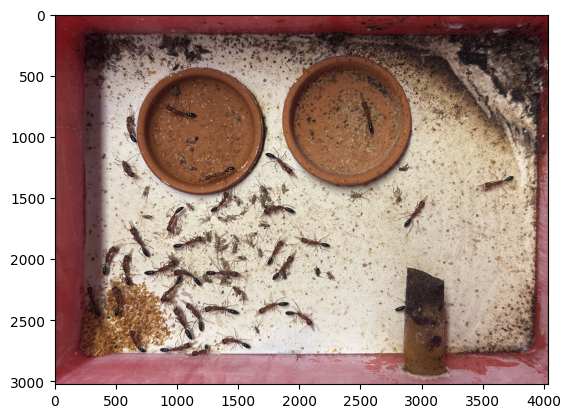

In [28]:
image_path = "ant_images/IMG_6644.jpeg"
image = io.imread(image_path)
plt.clf(); plt.imshow(image)

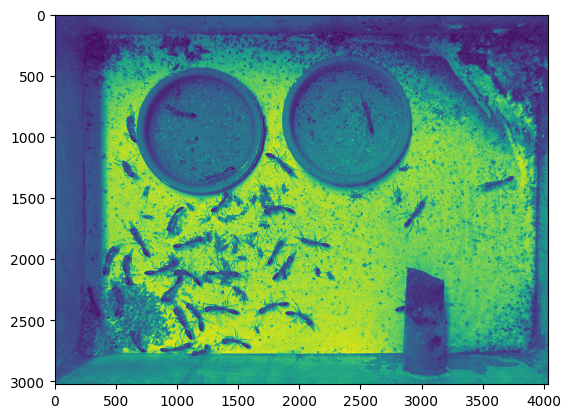

In [29]:
gray = color.rgb2gray(image)
plt.clf(); plt.imshow(gray)

In [36]:
sigma=2.0
min_size=30
max_size=500

# Step 1: Edge detection
edges = feature.canny(gray, sigma=sigma)

# Step 2: Morphological closing to fill small gaps in edges
filled = morphology.binary_closing(edges, morphology.disk(2))

# Step 3: Fill enclosed regions
filled = morphology.binary_fill_holes(filled)

# Step 4: Remove tiny noise
cleaned = morphology.remove_small_objects(filled, min_size=min_size)

# Step 5: Label and get region centroids
labeled = measure.label(cleaned)

AttributeError: module 'skimage.morphology' has no attribute 'binary_fill_holes'

In [ ]:
props = measure.regionprops(labeled)

input_points = []
for region in props:
    if min_size < region.area < max_size:
        y, x = region.centroid
        input_points.append([[int(x), int(y)]])

In [39]:
filled.sum()

909506